# Importing and Installing packages 

In [ ]:
import sys, subprocess

# Defining packages to be installed 
pkgs = [
    "torch",
    "transformers==4.48.0",
    "datasets",
    "accelerate",
    "scikit-learn",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn"
]

# Installing packages
for p in pkgs:
    print("Installing", p)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])
print("Done")

In [2]:
# VERIFYING GPU ACCESS

import torch
import sys

print("="*60)
print("GPU VERIFICATION")
print("="*60)

print(f"Python version: {sys.version.split()[0]}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("\n✅ GPU is available and ready!")
else:
    print("\n❌ NO GPU DETECTED - Training will be very slow!")
    print("Check your kernel/runtime settings")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


GPU VERIFICATION
Python version: 3.10.19
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU count: 1
GPU name: Tesla T4
GPU memory: 15.64 GB

✅ GPU is available and ready!


In [4]:
# Installing sentencepiece(required for Explainability tasks)
!pip install -U pip
!pip install "sentencepiece==0.1.99"

In [6]:
# Importing all libraries

# Core libraries
import torch
import numpy as np
import pandas as pd
import random
import time
import os
from collections import Counter

# Transformers and datasets
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset

# Sklearn metrics
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_recall_fscore_support, 
    balanced_accuracy_score,
    confusion_matrix,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


IMPORTING LIBRARIES


# Setting up Working Directory

In [7]:
# Setting up Working Directory

print("="*60)
print("SETTING UP WORKING DIRECTORY")
print("="*60)

# Defining paths for model and results
WORK_DIR = os.path.expanduser("~/HEARTS_Replication")
OUTPUT_DIR = os.path.join(WORK_DIR, "model_output_albertv2")
RESULTS_DIR = os.path.join(WORK_DIR, "results")
LOGS_DIR = os.path.join(WORK_DIR, "logs")

# Creating directories
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

print(f"Working directory: {WORK_DIR}")
print(f"Output directory:  {OUTPUT_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Logs directory:    {LOGS_DIR}")

# Changing to a working directory
os.chdir(WORK_DIR)
print(f"\n✅ Current directory: {os.getcwd()}")

SETTING UP WORKING DIRECTORY
Working directory: /home/ec2-user/HEARTS_Replication
Output directory:  /home/ec2-user/HEARTS_Replication/model_output_albertv2
Results directory: /home/ec2-user/HEARTS_Replication/results
Logs directory:    /home/ec2-user/HEARTS_Replication/logs

✅ Current directory: /home/ec2-user/HEARTS_Replication


# Loading dataset 

In [8]:
print("="*60)
print("LOADING EMGSD DATASET")
print("="*60)

# Loading dataset from HuggingFace
print("Downloading dataset from HuggingFace...")
dataset = load_dataset("holistic-ai/EMGSD")

print("\n✅ Dataset loaded successfully!")
print("\nDataset structure:")
print(dataset)

print(f"\nDataset sizes:")
print(f"  Train: {len(dataset['train']):,} examples")
print(f"  Test:  {len(dataset['test']):,} examples")
print(f"  Total: {len(dataset['train']) + len(dataset['test']):,} examples")

# Examining structure
print("\n" + "="*60)
print("DATASET STRUCTURE")
print("="*60)
print(f"Columns: {dataset['train'].column_names}")

print("\nFirst example:")
first_example = dataset['train'][0]
for key, value in first_example.items():
    if key == 'text':
        print(f"  {key}: {value[:100]}...")
    else:
        print(f"  {key}: {value}")

# Checking label distribution
print("\n" + "="*60)
print("LABEL ANALYSIS")
print("="*60)

# Counting 'category' values
train_categories = [ex['category'] for ex in dataset['train']]
test_categories = [ex['category'] for ex in dataset['test']]

train_dist = Counter(train_categories)
test_dist = Counter(test_categories)

print("\nCategory distribution:")
print(f"  Train: {dict(train_dist)}")
print(f"  Test:  {dict(test_dist)}")

print("\n✅ Dataset loaded and analyzed!")

LOADING EMGSD DATASET


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/45760 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11441 [00:00<?, ? examples/s]


✅ Dataset loaded successfully!

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['stereotype_type', 'text', 'text_with_marker', 'category', 'data_source', 'label'],
        num_rows: 45760
    })
    test: Dataset({
        features: ['stereotype_type', 'text', 'text_with_marker', 'category', 'data_source', 'label'],
        num_rows: 11441
    })
})

Dataset sizes:
  Train: 45,760 examples
  Test:  11,441 examples
  Total: 57,201 examples

DATASET STRUCTURE
Columns: ['stereotype_type', 'text', 'text_with_marker', 'category', 'data_source', 'label']

First example:
  stereotype_type: profession
  text: The illustrator had tower hands....
  text_with_marker: The illustrator had ===tower=== hands.
  category: unrelated
  data_source: stereoset_intrasentence
  label: unrelated

LABEL ANALYSIS

Category distribution:
  Train: {'unrelated': 14992, 'stereotype': 15597, 'neutral': 15171}
  Test:  {'stereotype': 3906, 'neutral': 3754, 'unrelated': 3781}

✅ Dataset load

# Preparing Labels  

In [9]:
print("="*60)
print("PREPARING LABELS FOR 3-CLASS CLASSIFICATION")
print("="*60)

# Defining label mapping, using the column "category"(stereotype, neutral, unrelated)
label_to_id = {
    'stereotype': 0,
    'neutral': 1,
    'unrelated': 2
}

id_to_label = {v: k for k, v in label_to_id.items()}

print(f"Label mapping: {label_to_id}")

# Adding numerical labels to dataset
def add_numeric_labels(examples):
    examples['labels'] = [label_to_id[cat] for cat in examples['category']]
    return examples

print("\nAdding numerical labels to dataset...")
dataset_with_labels = dataset.map(add_numeric_labels, batched=True)

# Verifying labels
print("\n" + "="*60)
print("VERIFICATION")
print("="*60)
print("\nFirst 5 examples with labels:")
for i in range(5):
    ex = dataset_with_labels['train'][i]
    print(f"  {i+1}. category='{ex['category']:12s}' → label={ex['labels']} ({id_to_label[ex['labels']]})")

# Counting final label distribution
train_labels = [ex['labels'] for ex in dataset_with_labels['train']]
test_labels = [ex['labels'] for ex in dataset_with_labels['test']]

print("\n" + "="*60)
print("FINAL LABEL DISTRIBUTION")
print("="*60)

# Printing label distribution
for label_id in sorted(id_to_label.keys()):
    label_name = id_to_label[label_id]
    train_count = train_labels.count(label_id)
    test_count = test_labels.count(label_id)
    total = train_count + test_count
    print(f"{label_name:12s} (label {label_id}): Train={train_count:,} ({train_count/len(train_labels)*100:.1f}%), Test={test_count:,} ({test_count/len(test_labels)*100:.1f}%)")

num_labels = 3
print(f"\n✅ Dataset prepared with {num_labels} classes")
print(f"   Total examples: {len(dataset_with_labels['train']) + len(dataset_with_labels['test']):,}")

PREPARING LABELS FOR 3-CLASS CLASSIFICATION
Label mapping: {'stereotype': 0, 'neutral': 1, 'unrelated': 2}

Adding numerical labels to dataset...


Map:   0%|          | 0/45760 [00:00<?, ? examples/s]

Map:   0%|          | 0/11441 [00:00<?, ? examples/s]


VERIFICATION

First 5 examples with labels:
  1. category='unrelated   ' → label=2 (unrelated)
  2. category='unrelated   ' → label=2 (unrelated)
  3. category='unrelated   ' → label=2 (unrelated)
  4. category='unrelated   ' → label=2 (unrelated)
  5. category='unrelated   ' → label=2 (unrelated)

FINAL LABEL DISTRIBUTION
stereotype   (label 0): Train=15,597 (34.1%), Test=3,906 (34.1%)
neutral      (label 1): Train=15,171 (33.2%), Test=3,754 (32.8%)
unrelated    (label 2): Train=14,992 (32.8%), Test=3,781 (33.0%)

✅ Dataset prepared with 3 classes
   Total examples: 57,201


# Loading the ALBERT-V2 Model

In [10]:
print("="*60)
print("LOADING ALBERT-V2 MODEL")
print("="*60)

# Defining model path
model_path = 'albert/albert-base-v2'
print(f"Model: {model_path}")
print(f"Loading from HuggingFace Hub...\n")

# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
print("✅ Tokenizer loaded")

# Loading model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)
print("✅ Model loaded")

print(f"\n" + "="*60)
print("MODEL CONFIGURATION")
print("="*60)
print(f"Base model:       {model_path}")
print(f"Number of labels: {num_labels}")
print(f"Label mapping:    {id_to_label}")
print(f"Max length:       512 tokens (HEARTS paper uses 512)")

# Checking for expected warning
print("\n⚠️  Expected warning above: 'classifier.bias' and 'classifier.weight' are")
print("   newly initialized, this is NORMAL for fine-tuning!")

print("\n✅ ALBERT-V2 model ready for training")

LOADING ALBERT-V2 MODEL
Model: albert/albert-base-v2
Loading from HuggingFace Hub...



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Tokenizer loaded


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded

MODEL CONFIGURATION
Base model:       albert/albert-base-v2
Number of labels: 3
Label mapping:    {0: 'stereotype', 1: 'neutral', 2: 'unrelated'}
Max length:       512 tokens (HEARTS paper uses 512)

⚠️  Expected warning above: 'classifier.bias' and 'classifier.weight' are
   newly initialized - this is NORMAL for fine-tuning!

✅ ALBERT-V2 model ready for training


# Tokenizing the dataset

In [11]:
print("="*60)
print("TOKENIZING DATASET")
print("="*60)

# Defining tokenization function (max_length=512, as prescribed by King et al.(2024))
def tokenize_function(examples):
    return tokenizer(
        examples["text"], 
        padding=True, 
        truncation=True, 
        max_length=512
    )

print("Tokenizing training set...")
# Removing columns not needed for training
columns_to_remove = ['stereotype_type', 'text', 'text_with_marker', 'category', 'data_source', 'label']

# Implementing the tokenization function
tokenized_train = dataset_with_labels['train'].map(
    tokenize_function, 
    batched=True, 
    remove_columns=columns_to_remove
)
print(f"✅ Train tokenized: {len(tokenized_train):,} examples")

print("Tokenizing test set...")
tokenized_test = dataset_with_labels['test'].map(
    tokenize_function, 
    batched=True, 
    remove_columns=columns_to_remove
)
print(f"✅ Test tokenized: {len(tokenized_test):,} examples")

# Verifying tokenized data
print("\n" + "="*60)
print("TOKENIZED DATA SAMPLE")
print("="*60)
print("Keys in tokenized example:", list(tokenized_train[0].keys()))
print(f"Input IDs length: {len(tokenized_train[0]['input_ids'])}")
print(f"Label: {tokenized_train[0]['labels']} ({id_to_label[tokenized_train[0]['labels']]})")

print("\n✅ Tokenization complete!")

TOKENIZING DATASET
Tokenizing training set...


Map:   0%|          | 0/45760 [00:00<?, ? examples/s]

✅ Train tokenized: 45,760 examples
Tokenizing test set...


Map:   0%|          | 0/11441 [00:00<?, ? examples/s]

✅ Test tokenized: 11,441 examples

TOKENIZED DATA SAMPLE
Keys in tokenized example: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Input IDs length: 48
Label: 2 (unrelated)

✅ Tokenization complete!


# Creating Train/Validation split

In [12]:
print("="*60)
print("CREATING TRAIN/VALIDATION SPLIT")
print("="*60)

# Spliting train into train/val (80/20 split, matching HEARTS paper)
print("Splitting training set (80% train, 20% validation)...")
train_val_split = tokenized_train.train_test_split(test_size=0.2, seed=42)

tokenized_train_final = train_val_split['train']
tokenized_val = train_val_split['test']

print("\n" + "="*60)
print("FINAL DATASET SPLITS")
print("="*60)
print(f"Training set:   {len(tokenized_train_final):,} examples")
print(f"Validation set: {len(tokenized_val):,} examples")
print(f"Test set:       {len(tokenized_test):,} examples")
print(f"Total:          {len(tokenized_train_final) + len(tokenized_val) + len(tokenized_test):,} examples")

# Calculating steps per epoch
steps_per_epoch = len(tokenized_train_final) // 64  # batch_size=64
total_steps = steps_per_epoch * 6  # 6 epochs

print(f"\nTraining steps:")
print(f"  Steps per epoch: ~{steps_per_epoch}")
print(f"  Total steps (6 epochs): ~{total_steps}")

print("\n✅ Dataset splits ready for training!")

CREATING TRAIN/VALIDATION SPLIT
Splitting training set (80% train, 20% validation)...

FINAL DATASET SPLITS
Training set:   36,608 examples
Validation set: 9,152 examples
Test set:       11,441 examples
Total:          57,201 examples

Training steps:
  Steps per epoch: ~572
  Total steps (6 epochs): ~3432

✅ Dataset splits ready for training!


# Defining evaluation metrics

In [13]:
print("="*60)
print("DEFINING EVALUATION METRICS")
print("="*60)

# Defining compute_metrics function, similar to the code provided by King et al.(2024)
def compute_metrics(eval_pred):
    """
    Compute metrics matching HEARTS paper:
    - Accuracy
    - Precision (macro)
    - Recall (macro)
    - F1 (macro)
    - Balanced accuracy
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculating metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    balanced_acc = balanced_accuracy_score(labels, predictions)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "balanced_accuracy": balanced_acc
    }

# Prining metrics
print("✅ Metrics defined:")
print("   - Accuracy")
print("   - Precision (macro)")
print("   - Recall (macro)")
print("   - F1 Score (macro)")
print("   - Balanced Accuracy")

print("\n✅ Evaluation metrics ready!")

DEFINING EVALUATION METRICS
✅ Metrics defined:
   - Accuracy
   - Precision (macro)
   - Recall (macro)
   - F1 Score (macro)
   - Balanced Accuracy

✅ Evaluation metrics ready!


# Defining Training Parameters 

In [14]:
# Configuring Training, as precribed by King et al. (2024)
print("="*60)
print("CONFIGURING TRAINING ARGUMENTS")
print("="*60)

# Setting random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to: {seed}")

# Defining training arguments, as precribed by King et al. (2024)
training_args = TrainingArguments(
    # Output
    output_dir=os.path.join(OUTPUT_DIR, "emgsd_trained"),
    logging_dir=LOGS_DIR,
    
    # Training hyperparameters
    num_train_epochs=6,                    
    learning_rate=2e-5,                    
    per_device_train_batch_size=64,       
    per_device_eval_batch_size=64,
    weight_decay=0.01,                     
    
    # Evaluation and saving
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,                    
    
    # Logging
    logging_steps=100,
    
    # Performance
    fp16=True,                             
    
    # Reproducibility
    seed=seed,
    
    # Disabling external logging
    report_to="none"
)

print("\n" + "="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Model:           albert/albert-base-v2")
print(f"Epochs:          {training_args.num_train_epochs}")
print(f"Batch size:      {training_args.per_device_train_batch_size}")
print(f"Learning rate:   {training_args.learning_rate}")
print(f"Weight decay:    {training_args.weight_decay}")
print(f"Max length:      512 tokens")
print(f"FP16:            {training_args.fp16}")
print(f"Seed:            {training_args.seed}")
print(f"\nOutput directory: {training_args.output_dir}")

print("\n✅ Training arguments configured")

CONFIGURING TRAINING ARGUMENTS
Random seed set to: 42

TRAINING CONFIGURATION
Model:           albert/albert-base-v2
Epochs:          6
Batch size:      64
Learning rate:   2e-05
Weight decay:    0.01
Max length:      512 tokens
FP16:            True
Seed:            42

Output directory: /home/ec2-user/HEARTS_Replication/model_output_albertv2/emgsd_trained

✅ Training arguments configured


# Model Training

In [15]:
print("="*60)
print("INITIALIZING TRAINER")
print("="*60)

# Initializing Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=tokenized_train_final,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

print("✅ Trainer initialized")

# Checking GPU
print("\n" + "="*60)
print("HARDWARE CHECK")
print("="*60)

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU: {gpu_name}")
    print(f"✅ GPU Memory: {gpu_memory:.2f} GB")
    print(f"✅ FP16 enabled: Faster training")
else:
    print("❌ NO GPU DETECTED!")
    print("   Training will be very slow")

# Beginning Training
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Training samples: {len(tokenized_train_final):,}")
print(f"Validation samples: {len(tokenized_val):,}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Steps per epoch: ~{len(tokenized_train_final) // training_args.per_device_train_batch_size}")
print(f"Total steps: ~{(len(tokenized_train_final) // training_args.per_device_train_batch_size) * training_args.num_train_epochs}")
print(f"\n⏱️  Estimated time: 30-60 minutes on GPU")
print(f"    (You can monitor progress below)")
print("="*60)
print()

# Recording start time
start_time = time.time()

# Training the model
print("🚀 Training started...\n")
train_result = trainer.train()

# Calculating training time using start_time
training_time = time.time() - start_time

# Displaying when training is completed
print("\n" + "="*60)
print("✅ TRAINING COMPLETED!")
print("="*60)
print(f"Total time: {training_time/60:.2f} minutes ({training_time/3600:.2f} hours)")
print(f"Average time per epoch: {training_time/training_args.num_train_epochs/60:.2f} minutes")

# Saving the model
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

model_save_path = os.path.join(OUTPUT_DIR, "emgsd_trained")
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved to: {model_save_path}")

# Storing training metadata
training_metadata = {
    'model_path': 'albert/albert-base-v2',
    'num_labels': num_labels,
    'label_mapping': label_to_id,
    'epochs': training_args.num_train_epochs,
    'batch_size': training_args.per_device_train_batch_size,
    'learning_rate': training_args.learning_rate,
    'weight_decay': training_args.weight_decay,
    'max_length': 512,
    'training_time_minutes': training_time/60,
    'train_size': len(tokenized_train_final),
    'val_size': len(tokenized_val),
    'test_size': len(tokenized_test),
    'seed': seed
}

# Printing training metadata
print("\n" + "="*60)
print("TRAINING METADATA")
print("="*60)
for key, value in training_metadata.items():
    if key != 'label_mapping':
        print(f"{key:25s}: {value}")

print("\n✅ HEARTS REPLICATION TRAINING COMPLETE!")
print("   Ready for evaluation...")


INITIALIZING TRAINER


/tmp/ipykernel_31878/4288036437.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


✅ Trainer initialized

HARDWARE CHECK
✅ GPU: Tesla T4
✅ GPU Memory: 15.64 GB
✅ FP16 enabled: Faster training

STARTING TRAINING
Training samples: 36,608
Validation samples: 9,152
Epochs: 6
Steps per epoch: ~572
Total steps: ~3432

⏱️  Estimated time: 30-60 minutes on GPU
    (You can monitor progress below)

🚀 Training started...



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Balanced Accuracy
1,0.742800,0.573281,0.727928,0.730601,0.728041,0.725180,0.728041
2,0.465300,0.480083,0.785402,0.783649,0.785572,0.783931,0.785572
3,0.369000,0.451524,0.809003,0.810541,0.809099,0.808734,0.809099
4,0.292300,0.458666,0.815669,0.813851,0.815807,0.814070,0.815807
5,0.213700,0.503235,0.819056,0.820491,0.819289,0.819004,0.819289
6,0.125400,0.552944,0.815450,0.816404,0.815642,0.815851,0.815642



✅ TRAINING COMPLETED!
Total time: 14.68 minutes (0.24 hours)
Average time per epoch: 2.45 minutes

SAVING MODEL
✅ Model saved to: /home/ec2-user/HEARTS_Replication/model_output_albertv2/emgsd_trained

TRAINING METADATA
model_path               : albert/albert-base-v2
num_labels               : 3
epochs                   : 6
batch_size               : 64
learning_rate            : 2e-05
weight_decay             : 0.01
max_length               : 512
training_time_minutes    : 14.676026300589244
train_size               : 36608
val_size                 : 9152
test_size                : 11441
seed                     : 42

✅ HEARTS REPLICATION TRAINING COMPLETE!
   Ready for evaluation...


# Model Evaluation

In [16]:
print("="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Beginning evaluation on test set
print("Running evaluation on test set...")
print("(This will take 1-2 minutes)\n")

eval_results = trainer.evaluate(tokenized_test)

print("✅ Evaluation complete!\n")

print("="*60)
print("TEST SET RESULTS")
print("="*60)

for key, value in sorted(eval_results.items()):
    if isinstance(value, float):
        print(f"{key:25s}: {value:.4f}")

# Obtaining predictions for detailed analysis
print("\n" + "="*60)
print("GENERATING PREDICTIONS FOR ANALYSIS")
print("="*60)

predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
pred_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

print(f"✅ Predictions generated")
print(f"   Total predictions: {len(pred_labels):,}")

# Calculating key metrics
final_accuracy = accuracy_score(true_labels, pred_labels)
final_f1_macro = f1_score(true_labels, pred_labels, average='macro')
final_f1_weighted = f1_score(true_labels, pred_labels, average='weighted')

print("\n" + "="*60)
print("FINAL METRICS")
print("="*60)
print(f"Accuracy:        {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(f"F1 (Macro):      {final_f1_macro:.4f}")
print(f"F1 (Weighted):   {final_f1_weighted:.4f}")

# Storing results
replication_results = {
    'accuracy': final_accuracy,
    'f1_macro': final_f1_macro,
    'f1_weighted': final_f1_weighted,
    'precision': eval_results.get('eval_precision', 0),
    'recall': eval_results.get('eval_recall', 0),
    'balanced_accuracy': eval_results.get('eval_balanced_accuracy', 0)
}

print("\n✅ Test set evaluation complete!")

EVALUATING ON TEST SET
Running evaluation on test set...
(This will take 1-2 minutes)



✅ Evaluation complete!

TEST SET RESULTS
epoch                    : 6.0000
eval_accuracy            : 0.8118
eval_balanced_accuracy   : 0.8127
eval_f1                  : 0.8128
eval_loss                : 0.5232
eval_precision           : 0.8146
eval_recall              : 0.8127
eval_runtime             : 13.9945
eval_samples_per_second  : 817.5340
eval_steps_per_second    : 12.7910

GENERATING PREDICTIONS FOR ANALYSIS
✅ Predictions generated
   Total predictions: 11,441

FINAL METRICS
Accuracy:        0.8118 (81.18%)
F1 (Macro):      0.8128
F1 (Weighted):   0.8123

✅ Test set evaluation complete!


# Comparing with King et al. (2024)

In [26]:
# Comparing F1 Score of the trained model against the model trained by King et al. (2024)
print("="*60)
print("COMPARISON WITH HEARTS FRAMEWORK (F1 SCORE)")
print("="*60)

# The F1 Score reported by King et al. (2024)
paper_f1 = 0.815   # 81.5%

# The F1 Score of the model I trained
your_f1 = eval_results["eval_f1"]

# Computing difference between the two F1 scores
difference = abs(paper_f1 - your_f1)
difference_pct = difference * 100

# Defining the threshold for replication success (±5%), as per the coursework guidelines
threshold = 0.05
success = difference <= threshold

print(f"\nPaper F1 Score:        {paper_f1:.4f}   ({paper_f1*100:.2f}%)")
print(f"Your Model F1 Score:   {your_f1:.4f}   ({your_f1*100:.2f}%)")
print(f"Difference:            {difference_pct:.2f}%")

if success:
    print("\n✅ SUCCESS! The replication is within ±5% of the model trained by King et al. (2024).")
else:
    print("\n⚠️  WARNING: The replication differs by more than ±5%.")
    print("   Check training setup, tokenization, or label mapping.")

print("\n✅ F1 comparison complete!")


COMPARISON WITH HEARTS PAPER (F1 SCORE)

Paper F1 Score:        0.8150   (81.50%)
Your Model F1 Score:   0.8128   (81.28%)
Difference:            0.22%

✅ SUCCESS! The replication is within ±5% of the model trained by King et al. (2024).

✅ F1 comparison complete!


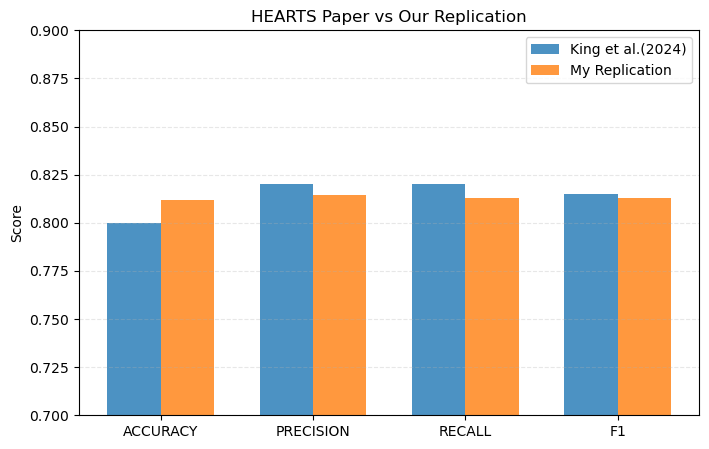

In [31]:
# Metrics obtained by King et al. (2024)
paper_metrics = {
    "accuracy": 0.80, # Authors reported an accuracy of over 80 per-cent
    "precision": 0.82,
    "recall": 0.82,
    "f1": 0.815   # reported macro-F1
}

# Metrics obtained by replication
our_metrics = {
    "accuracy": replication_results["accuracy"],
    "precision": replication_results["precision"],
    "recall": replication_results["recall"],
    "f1": replication_results["f1_macro"]
}

metrics = list(paper_metrics.keys())
paper_vals = [paper_metrics[m] for m in metrics]
our_vals   = [our_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

# Plotting a bar plot contrasting paper metrics and the metrics obtained through replication
plt.figure(figsize=(8,5))
plt.bar(x - width/2, paper_vals, width, label='King et al.(2024)', alpha=0.8)
plt.bar(x + width/2, our_vals, width, label='My Replication', alpha=0.8)

plt.xticks(x, [m.upper() for m in metrics])
plt.ylabel("Score")
plt.title("HEARTS Paper vs Our Replication")
plt.ylim(0.70, 0.90)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.show()
